## Tomato Cantilever

In [1]:
# import numpy as np
# import os

# n_nodes = 100
# l = 0.5  # m

# # create a 3D array of shape (n_nodes, 3)
# coords = np.zeros((n_nodes, 3))
# coords[:, 2] = np.linspace(0, l, n_nodes)  # z-coordinates

# # create edges array of shape (n_nodes-1, 2)
# # need one-based indexing for the edges
# edges = np.zeros((n_nodes - 1, 2), dtype=int)
# edges[:, 0] = np.arange(1, n_nodes)
# edges[:, 1] = np.arange(2, n_nodes + 1)

# # ensure directory exists
# out_path = "../tests/resources/tomato_pollination/mesh.txt"
# os.makedirs(os.path.dirname(out_path), exist_ok=True)

# # write to mesh.txt with comma separation
# with open(out_path, "w") as f:
#     f.write("*Nodes\n")
#     np.savetxt(f, coords, delimiter=", ", fmt="%.6f")  # 6 decimals for readability
#     f.write("*Edges\n")
#     np.savetxt(f, edges, delimiter=", ", fmt="%d")


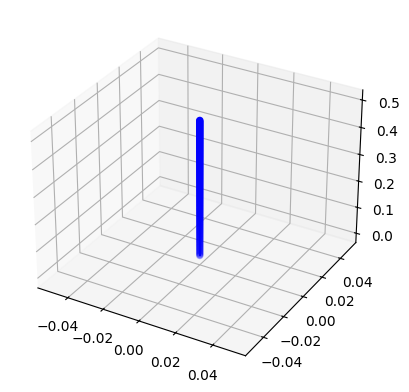

In [2]:
import numpy as np
import time
import dismech

geom = dismech.GeomParams(
    rod_r0=2e-2,
    shell_h=0.0,
)

material = dismech.Material(density=1500,
                            youngs_rod=3.16e7,
                            # youngs_rod=5e9,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

dyn_sim = dismech.SimParams(static_sim=False,
                                  two_d_sim=True,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-2,
                                  max_iter=50,
                                  total_time=1,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2
                                  )

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))
env.add_force('damping', eta=100)

geo = dismech.Geometry.from_txt(
    '../tests/resources/tomato_pollination/mesh.txt')

robot = dismech.SoftRobot(geom, material, geo, dyn_sim, env)

### Move the stem: Moving BC

1. Move the base

In [3]:
# main_grip = 6

# print("Main grip node:", main_grip)

# other_grip_nodes_below = np.array([3, 4, 5], dtype=int)
# other_grip_nodes_above = np.array([9, 8, 7], dtype=int)

2. Move the middle

In [4]:
main_grip = 50

print("Main grip node:", main_grip)

other_grip_nodes_below = np.array([47, 48, 49], dtype=int)
other_grip_nodes_above = np.array([53, 52, 51], dtype=int)

Main grip node: 50


3. Move the top

In [5]:
# main_grip = 96

# print("Main grip node:", main_grip)

# other_grip_nodes_below = np.array([93, 94, 95], dtype=int)
# other_grip_nodes_above = np.array([99, 98, 97], dtype=int)

In [6]:
# # Keep an explicit order: main first, then others
grip_nodes = np.r_[main_grip, other_grip_nodes_below].astype(int)


# base_nodes = np.where((robot.state.q[robot.node_dof_indices].reshape(-1, 3)[:, 2]) < 0.234)[0] # fixed base
base_nodes = np.array([0, 1, 2], dtype=int)

# Fix: main_grip node + base nodes
robot = robot.fix_nodes(np.unique(np.r_[main_grip, base_nodes]))

# --- define the distributed shaking on grip nodes only ---
def shake_distributed(robot: dismech.SoftRobot, t: float):
    """Moving boundary condition on grip_nodes with linearly scaled amplitudes."""
    amplitude = 0.001  # meters at main grip node
    #### amplitude = 0.004  # converges for "move the middle" case
    frequency = 5.0    # Hz

    xyz = robot.state.q[robot.node_dof_indices].reshape(-1, 3)

    # Reference length: distance main <-> first stationary node in your list
    # If you meant a specific stationary anchor, pick it explicitly; here we use the
    # first of your "other" nodes that exists.

    L_ref = np.linalg.norm(xyz[main_grip] - xyz[grip_nodes[1]])

    # Build amplitudes aligned to grip_nodes order
    all_grip_nodes = np.r_[grip_nodes, other_grip_nodes_above]
    amps = np.empty(all_grip_nodes.size, dtype=float)
    amps[0] = amplitude  # main node
    for i in range(1, grip_nodes.size):
        dist = np.linalg.norm(xyz[grip_nodes[1]] - xyz[grip_nodes[i]])
        amps[i] = amplitude * (dist / L_ref)

    # Also move the "above" nodes
    L_ref_above = np.linalg.norm(xyz[main_grip] - xyz[other_grip_nodes_above[0]])
    for node in other_grip_nodes_above:
        dist = np.linalg.norm(xyz[other_grip_nodes_above[0]] - xyz[node])
        amps[i+1] = amplitude * (dist / L_ref_above)
        i = i + 1

    # print("Amplitudes:", amps)
    # print("Grip nodes:", all_grip_nodes)
    
    # Sinusoidal displacement along +X
    disp_x = amps * np.sin(2 * np.pi * frequency * t)
    disp = np.column_stack([disp_x, np.zeros_like(disp_x), np.zeros_like(disp_x)])  # (N,3)

    # Move ONLY the grip nodes (root nodes are already fixed)
    robot = robot.move_nodes(all_grip_nodes, disp.reshape(-1,1).flatten())
    return robot

stepper = dismech.ImplicitEulerTimeStepper(robot)
stepper.before_step = shake_distributed

In [7]:
print("grasping points:", grip_nodes)

grasping points: [50 47 48 49]


### Simulate

In [8]:
# simulate
robots = stepper.simulate()

qs = np.stack([robot.state.q for robot in robots])

iter: 1, error: 14199.479
iter: 2, error: 240.827
current_time:  0.01
iter: 1, error: 27010.032
iter: 2, error: 1079.687
iter: 3, error: 21.998
current_time:  0.02
iter: 1, error: 37176.326
iter: 2, error: 2670.908
iter: 3, error: 266.846
current_time:  0.03
iter: 1, error: 43701.308
iter: 2, error: 8695.561
iter: 3, error: 3159.220
iter: 4, error: 43.774
current_time:  0.04
iter: 1, error: 45946.362
iter: 2, error: 5656.342
iter: 3, error: 1344.387
current_time:  0.05
iter: 1, error: 43691.487
iter: 2, error: 11535.137
iter: 3, error: 4497.114
iter: 4, error: 138.929
iter: 5, error: 1.180
current_time:  0.06
iter: 1, error: 37161.428
iter: 2, error: 3070.883
iter: 3, error: 466.781
current_time:  0.07
iter: 1, error: 26994.439
iter: 2, error: 1143.472
iter: 3, error: 40.085
current_time:  0.08
iter: 1, error: 14189.228
iter: 2, error: 259.676
current_time:  0.09
iter: 1, error: 1.803
iter: 2, error: 1.461
current_time:  0.1
iter: 1, error: 14185.169
iter: 2, error: 237.990
current_tim

### Plotting

In [9]:
t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)
options = dismech.AnimationOptions(title='Tomato plant')

fig = dismech.get_interactive_animation_plotly(robot, t, qs , options)
fig.show()

100


/home/radha/Desktop/PhD/dismech-python/dismech-python/src/dismech/animation.py:72: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



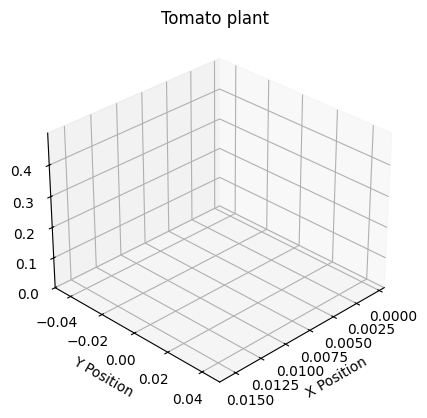

In [10]:
# save gif
ani = dismech.get_animation(robot, t, qs, options)
ani.save('tomato.gif')

Text(0.5, 1.0, 'X Position of Selected Nodes Over Time')

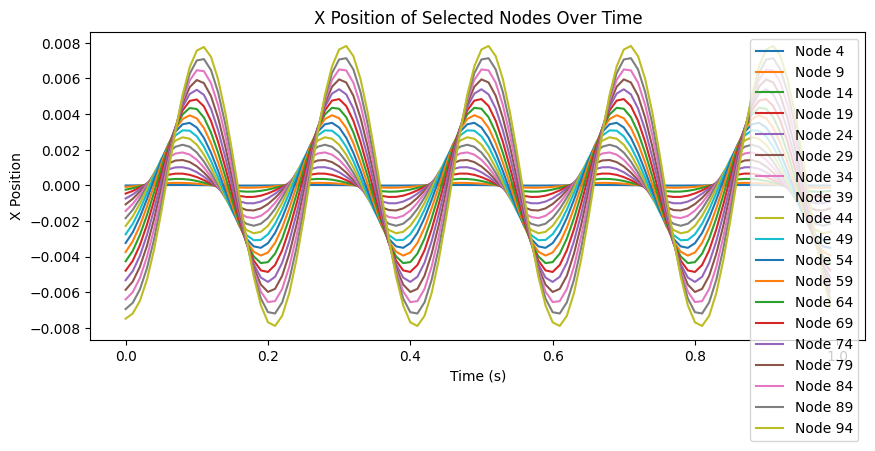

In [11]:
import matplotlib.pyplot as plt
# nodes on main stem
stem_nodes = np.arange(4, robot.n_nodes-1, 5)
nodes_to_plot = stem_nodes
# create plots of the x-coordinate of these nodes over time in the same plot
plt.figure(figsize=(10, 4))
for node in nodes_to_plot:
    node_dofs = robot.map_node_to_dof(node)
    node_x = qs[:, node_dofs[0]].squeeze()  # x-coordinate
    node_x -= node_x.mean()  # remove mean for better visualization
    plt.plot(t, node_x, label=f'Node {node}')
    legend = plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('X Position')
plt.title('X Position of Selected Nodes Over Time')

In [12]:
import numpy as np
from scipy.signal import hilbert, detrend, find_peaks

def avg_cycle_amplitude_hilbert(x: np.ndarray) -> float:
    """
    Robust average oscillation amplitude using the analytic-signal envelope.
    Returns the median envelope value (less sensitive to outliers).
    """
    x = np.asarray(x).ravel()
    x = detrend(x)  # remove slow drift
    envelope = np.abs(hilbert(x))
    # Use median to resist occasional spikes; mean is also fine.
    return float(np.median(envelope))

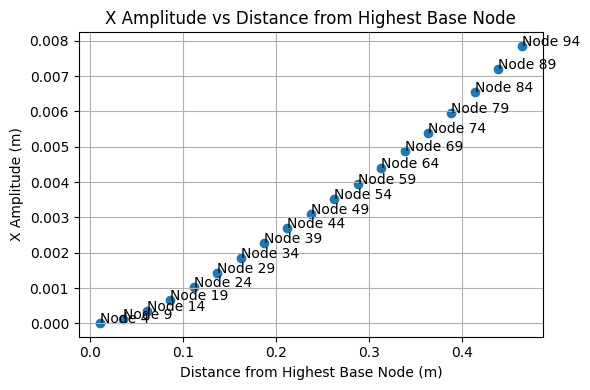

amplitudes: [1.564723830023671e-05, 0.00013750153568341874, 0.0003601479415874333, 0.0006625981690485044, 0.0010242641858460911, 0.0014243125472084863, 0.0018427739768278719, 0.002269456217029615, 0.0026895497548808833, 0.0031098915745554363, 0.0035200352802249963, 0.003939844639829263, 0.004388426270326101, 0.0048735651536165134, 0.0053985355961386605, 0.005962110352651561, 0.006560668769550276, 0.007187208145833581, 0.007844399783205027]


In [13]:
# plot the amplitudes of the above nodes in a plot against the distance of the node's z-coordinate from the highest base_node
# get the z-coordinate of the highest base node
base_node_z = robot.state.q[robot.node_dof_indices].reshape(-1, 3)[base_nodes, 2]
highest_base_node_z = np.max(base_node_z)
distances = []
amplitudes = []
for node in nodes_to_plot:
    node_dofs = robot.map_node_to_dof(node)
    node_z = robot.state.q[node_dofs[2]]
    distance = node_z - highest_base_node_z
    distances.append(distance)
    node_x = qs[:, node_dofs[0]].squeeze()  # x-coordinate
    # amplitude = (node_x.max() - node_x.min()) / 2
    amplitude = avg_cycle_amplitude_hilbert(node_x)     # averaged over time amplitude
    amplitudes.append(amplitude)    
plt.figure(figsize=(6, 4))
plt.scatter(distances, amplitudes)
for i, node in enumerate(nodes_to_plot):
    plt.text(distances[i], amplitudes[i], f'Node {node}')
plt.xlabel('Distance from Highest Base Node (m)')
plt.ylabel('X Amplitude (m)')
plt.title('X Amplitude vs Distance from Highest Base Node')
plt.grid(True)
plt.tight_layout()
plt.show()
print("amplitudes:", amplitudes)

In [14]:
# # plot the amplitudes of the above nodes in a plot against the distance of the node's z-coordinate from the highest base_node
# # get the z-coordinate of the highest base node
# base_node_z = robot.state.q[robot.node_dof_indices].reshape(-1, 3)[base_nodes, 2]
# highest_base_node_z = np.max(base_node_z)
# distances = []
# amplitudes = []
# for node in nodes_to_plot:
#     node_dofs = robot.map_node_to_dof(node)
#     node_z = robot.state.q[node_dofs[2]]
#     distance = node_z - highest_base_node_z
#     distances.append(distance)
#     node_x = qs[:, node_dofs[0]].squeeze()  # x-coordinate
#     amplitude = (node_x.max() - node_x.min()) / 2
#     # amplitude = avg_cycle_amplitude_hilbert(node_x)     # averaged over time amplitude
#     amplitudes.append(amplitude)    
# plt.figure(figsize=(6, 4))
# plt.scatter(distances, amplitudes)
# for i, node in enumerate(nodes_to_plot):
#     plt.text(distances[i], amplitudes[i], f'Node {node}')
# plt.xlabel('Distance from Highest Base Node (m)')
# plt.ylabel('X Amplitude (m)')
# plt.title('X Amplitude vs Distance from Highest Base Node')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print("amplitudes:", amplitudes)

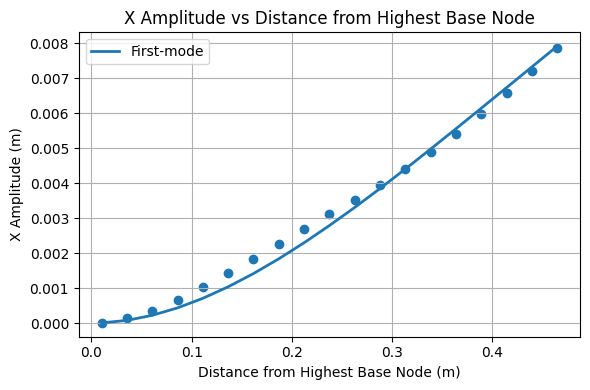

In [15]:
# === Append this AFTER your existing scatter plot code ===
import numpy as np
import matplotlib.pyplot as plt

# Convert to arrays
d = np.asarray(distances, dtype=float)       # distances from base (m)
a = np.asarray(amplitudes, dtype=float)      # measured amplitudes (m)

# Beam length assumed as farthest sample distance
L = float(d.max())
xi = d / L

# Cantilever first bending mode shape (normalized to tip = 1)
beta = 1.875104068711961  # first root where cosh(beta)*cos(beta) = -1
alpha = (np.cosh(beta) + np.cos(beta)) / (np.sinh(beta) + np.sin(beta))

phi_raw = (
    np.cosh(beta * xi) - np.cos(beta * xi)
    - alpha * (np.sinh(beta * xi) - np.sin(beta * xi))
)
# Normalize so that phi(ξ=1) = 1
phi_tip = (
    np.cosh(beta) - np.cos(beta)
    - alpha * (np.sinh(beta) - np.sin(beta))
)
phi = phi_raw / phi_tip

# Best-fit vertical scale to your amplitudes: minimize ||a - s*phi||
s = (phi @ a) / (phi @ phi)
mode_fit = s * phi

# Overlay as a line (sorted by distance for a clean curve)
order = np.argsort(d)
plt.figure(figsize=(6, 4))
plt.scatter(distances, amplitudes)
# for i, node in enumerate(nodes_to_plot):
#     plt.text(distances[i], amplitudes[i], f'Node {node}')

plt.plot(d[order], mode_fit[order], lw=2, label='First-mode')
plt.xlabel('Distance from Highest Base Node (m)')
plt.ylabel('X Amplitude (m)')
plt.title('X Amplitude vs Distance from Highest Base Node')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


### Save data for rendering

In [16]:
from dismech.logging import logDataForRendering
rod_data, shell_data = logDataForRendering(qs, t.reshape(-1, 1), robot, len(t), robot.sim_params.static_sim, robot.map_node_to_dof)

from dismech.logging import export_rod_shell_data
export_rod_shell_data(robot, rod_file='rawDataRod.txt', shell_file='rawDataShell.txt',
                          rod_js='rodData.js', shell_js='shellData.js',
                          rod_radius=0.1, scaleFactor=100)

(100, 400) (100, 1) (100, 399)
(0,)
0


/home/radha/Desktop/PhD/dismech-python/dismech-python/src/dismech/logging.py:100: UserWarning:

loadtxt: input contained no data: "rawDataShell.txt"



### Estimated values of parameters

In [17]:
L = 0.292 # m
r0 = 0.0059 # m

delta = 0.054 # m # delta = PL^3/(3EI)
P = 0.02*9.81 # N

K = P/delta # effective stiffness

I = np.pi * r0**4 / 4
E = P*(L**3) / (3 * I * delta)

print("E:", E)

f = 1.38 # Hz
TP = 0.725 # s

omega = 2 * np.pi * f
m_eff = K / omega**2
print("m_eff:", m_eff)

# estimate density
V = np.pi * r0**2 * L
rho = m_eff / V
print("rho:", rho)

E: 31683606.79586816
m_eff: 0.048326721526529885
rho: 1513.389046285066
